In [1]:
import pandas as pd
import numpy as np
from rfpimp import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from fastai.imports import *

from matplotlib import pyplot as plt
import glob2 as glob
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

In [2]:

# size_2015 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/size_2015*.csv')], ignore_index=True)
# trip_2015 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/trip_2015*.csv')], ignore_index = True)

# size_2016 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/size_2016*.csv')], ignore_index=True)
# trip_2016 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/trip_2016*.csv')], ignore_index = True)

size_2017 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/size_2017*.csv')], ignore_index=True)
trip_2017 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/trip_2017*.csv')], ignore_index = True)

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (26,39,65,73) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Many of the ID codes are messed up and aren't actually numbers...they end in XX instead. We will make these into NaN

In [3]:
ids=[]
for idno in trip_2017.ID_CODE:
    try: ids.append(int(idno))
    except: ids.append(np.nan)

In [4]:
trip_2017['new_id']=ids
sum(trip_2017.new_id.isnull())

68

## Choose the columns that aren't obviously cheating:


In [5]:
size_cols = ['AREA_X', 'ID_CODE', 'MODE_FX', 'ST', 'SUB_REG', 'WAVE', 'YEAR', 'kod', 'common'].copy()
trip_cols = ['prim1_common', 'prim2_common', 'AREA', 'BOAT_HRS', 'CNTRBTRS','CNTY','CNTY_RES','COASTAL','DIST',
            'FFDAYS12', 'FFDAYS2', 'GEAR', 'HRSF', 'new_id','MODE_F','month','new_list','PARTY',
            'PVT_RES','REG_RES','ST_RES' ].copy()

In [6]:
size2017 = size_2017[size_cols].copy()
trip2017 = trip_2017[trip_cols].copy()


In [7]:
merged = pd.merge(size2017,trip2017,how='inner', left_on=['ID_CODE'], right_on=['new_id'])

In [8]:
print(sum(merged.common.isnull()))
print(len(merged.common))

35662
176809


Drop the fish that you don't have any name for. We can't use these for training.

In [9]:
mask = merged.common.isnull()
data = merged[mask==False]

fill the NA values of "primary fish sought" using "NONE" for NA values

In [10]:
data.prim1_common.fillna(value='NONE', inplace=True)

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Drop the ID_CODE column and anything else that is leaky data

In [11]:
data.drop(columns=['new_id', 'ID_CODE'], inplace=True)

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
AREA_X,141147.0,3.284158,1.637909,1.0,2.0,3.0,5.0,5.0
MODE_FX,141147.0,5.437905,1.439681,3.0,4.0,5.0,7.0,7.0
ST,141147.0,24.695594,13.869487,1.0,12.0,25.0,37.0,51.0
SUB_REG,141147.0,5.559140,1.162565,4.0,4.0,6.0,7.0,7.0
WAVE,141147.0,3.856122,1.249568,1.0,3.0,4.0,5.0,6.0
YEAR,141147.0,2017.000000,0.000000,2017.0,2017.0,2017.0,2017.0,2017.0
BOAT_HRS,83618.0,6.805287,3.665669,1.0,4.5,6.5,8.5,99.9
CNTRBTRS,141147.0,2.238546,1.959931,0.0,1.0,1.0,3.0,20.0
CNTY,141147.0,79.099648,154.184575,1.0,11.0,37.0,87.0,810.0
CNTY_RES,141147.0,86.435362,148.322183,0.0,15.0,51.0,101.0,999.0


To DO: FILLNA for new_list (is the vehicle on a list?)
FILLNA FOR PARTY
FILLNA FOR HRSF
FILLNA FOR GEAR, BOAT HRS

This should all be taken care of by proc_df

In [13]:
data.head()

,AREA_X,MODE_FX,ST,SUB_REG,WAVE,YEAR,kod,common,prim1_common,prim2_common,...,FFDAYS2,GEAR,HRSF,MODE_F,month,new_list,PARTY,PVT_RES,REG_RES,ST_RES
9,5,3,9,4,5,2017,we,ATLANTIC SILVERSIDE,NONE,NaN,...,60.0,3.0,6.0,1.0,9,NaN,NaN,1.0,4.0,9.0
13,5,3,9,4,5,2017,wd,ATLANTIC MENHADEN,BLUEFISH,STRIPED BASS,...,12.0,1.0,8.0,1.0,9,NaN,NaN,1.0,4.0,9.0
14,5,3,9,4,5,2017,wd,ATLANTIC MENHADEN,BLUEFISH,STRIPED BASS,...,12.0,1.0,8.0,1.0,9,NaN,NaN,1.0,4.0,9.0
15,5,3,9,4,5,2017,wd,ATLANTIC MENHADEN,BLUEFISH,STRIPED BASS,...,12.0,1.0,8.0,1.0,9,NaN,NaN,1.0,4.0,9.0
16,5,3,9,4,5,2017,wd,ATLANTIC MENHADEN,BLUEFISH,STRIPED BASS,...,12.0,1.0,8.0,1.0,9,NaN,NaN,1.0,4.0,9.0


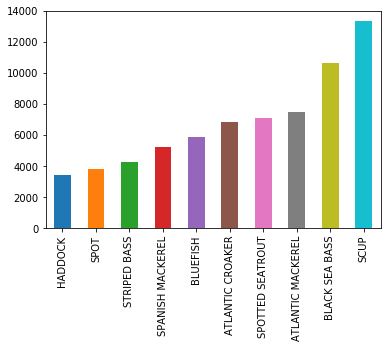

In [14]:
counts = merged['common'].value_counts()
counts.sort_values(inplace=True)

counts[-10:].plot(kind='bar')

In [15]:
fish = counts.sum()
rates = [x/fish*100 for x in counts]
rates[-10:]

[2.422297321232474,
 2.731903618213636,
 3.020963959559891,
 3.714567082545148,
 4.171537475114597,
 4.836801348948259,
 5.018172543518459,
 5.327070359270831,
 7.54532508661183,
 9.446888704683769]

In [16]:
def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    ignore_flds: A list of fields that are ignored during processing.
    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1

def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.
    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category {a : 1, b : 2}
    >>> df2 = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['b', 'a', 'a']})
    >>> apply_cats(df2, df)
           col1 col2
        0     1    b
        1     2    a
        2     3    a
    now the type of col is category {a : 1, b : 2}
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

In [17]:
# train_cats(data)
# df, y, nas = proc_df(data, 'common')

In [18]:
# data.dtypes

In [35]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

# n_valid = 53000
# n_trn = len(df)-n_valid
# raw_train, raw_valid = split_vals(data, n_trn)
# X_train, X_valid = split_vals(df, n_trn)
# y_train, y_valid = split_vals(y, n_trn)

# X_train.shape, y_train.shape, X_valid.shape

In [36]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [21]:
# m = RandomForestClassifier(n_jobs=-1)
# %time m.fit(X_train, y_train)
# print_score(m)

In [22]:
# imp = importances(m4, X_valid, y_valid, n_samples=-1)
# viz = plot_importances(imp)
# viz.view()

In [23]:
# imp

Ok, so some of these features are actually _detrimental_ to predicting fish species. One of them is the number of days that you've been fishing in the past 2 months. Another is whether it's on the vehicle directory or not. Weirdly, the absence of a response had some predictive power. But we'll just remove the variable so that we have an intuitive and useful model.

In [24]:
## new columns to use
new_cols = ['prim1_common','SUB_REG','AREA','AREA_X','MODE_FX','BOAT_HRS',
            'month','CNTRBTRS','FFDAYS12','common']
data2=data[new_cols].copy()

In [25]:
data2.head()

,prim1_common,SUB_REG,AREA,AREA_X,MODE_FX,BOAT_HRS,month,CNTRBTRS,FFDAYS12,common
9,NONE,4,C,5,3,NaN,9,1.0,100.0,ATLANTIC SILVERSIDE
13,BLUEFISH,4,C,5,3,NaN,9,1.0,20.0,ATLANTIC MENHADEN
14,BLUEFISH,4,C,5,3,NaN,9,1.0,20.0,ATLANTIC MENHADEN
15,BLUEFISH,4,C,5,3,NaN,9,1.0,20.0,ATLANTIC MENHADEN
16,BLUEFISH,4,C,5,3,NaN,9,1.0,20.0,ATLANTIC MENHADEN


In [26]:
# data2.prim1_common.astype('category')
cats=['prim1_common', 'SUB_REG', 'AREA', 'AREA_X', 'MODE_FX', 'month','common']

for item in cats:
    data2[item]=data2[item].astype('category')

In [27]:
data2.dtypes

prim1_common    category
SUB_REG         category
AREA            category
AREA_X          category
MODE_FX         category
BOAT_HRS         float64
month           category
CNTRBTRS         float64
FFDAYS12         float64
common          category
dtype: object

In [28]:
# train_cats(data2)
df2, y2, nas2 = proc_df(data2, 'common')

In [29]:
df2.columns

Index(['prim1_common', 'SUB_REG', 'AREA', 'AREA_X', 'MODE_FX', 'BOAT_HRS',
       'month', 'CNTRBTRS', 'FFDAYS12', 'BOAT_HRS_na'],
      dtype='object')

In [37]:
n_valid = 53000
n_trn = len(df2)-n_valid
raw_train, raw_valid = split_vals(data2, n_trn)
X_train, X_valid = split_vals(df2, n_trn)
y_train, y_valid = split_vals(y2, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((88147, 10), (88147,), (53000, 10))

In [38]:
# m2 = RandomForestClassifier(n_jobs=-1)
# %time m2.fit(X_train, y_train)
# print_score(m2)

In [39]:
df_test = pd.DataFrame()
df_test['a'] = y2

print(len(df_test.a.unique()))
print(len(data2.common.unique()))

315
315


In [40]:
m3 = RandomForestClassifier(n_estimators=10,n_jobs=-1)
%time m3.fit(X_train, y_train)
print_score(m3)

CPU times: user 1.93 s, sys: 402 ms, total: 2.33 s
Wall time: 1.4 s
[34.88187183642531, 53.25955047670917, 0.7726638456215186, 0.3479056603773585]


In [41]:
checker = np.array(X_valid.loc[108660])

In [42]:
probs = m3.predict_proba(checker.reshape(1,-1))

In [52]:
m3.classes_

array([  0,   1,   2,   3, ..., 310, 311, 313, 314], dtype=int16)

In [70]:
probs

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.]])

In [72]:
ihatethis = pd.DataFrame()

ihatethis['probs2'] = probs



ihatethis.head

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

get the list of probabilities, get the list of classes, put them both in a dataframe and then iterate?

In [58]:
problist = probs.T
classes = m3.classes_.T
trial = pd.DataFrame()
trial['Class'] = classes
trial['Probs'] = problist

In [65]:
trial.sort_values(by=['Probs'], ascending='False')

,Class,Probs
0,0,0.0
169,195,0.0
170,196,0.0
171,197,0.0
172,198,0.0
173,199,0.0
174,201,0.0
175,202,0.0
176,203,0.0
177,204,0.0


# Maybe you can make a confusion matrix? Because you're so confused? Lol no because it would be relevant

In [43]:
preds_idx = np.argsort(probs, axis=1)[-2:]

In [44]:
preds_idx

array([[  0, 169, 170, 171, ...,  96,  83, 267, 228]])

In [57]:
for i in X_valid.loc[108660]:
    print (i)
    
#     for p in preds_idx[i]:
#         print(m3.classes_,[p],probs[i][p])

140
2
11
5
3
7.5
6
6.0
3.0
False


In [56]:
thinking: 
    if get the order and unique of the columns and then the names of them it will work (like before, dummy)
    
    

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.]])

In [59]:
print(data2.common.cat.codes.unique())
print(data2.common.unique())

[ 18  15 220 277 ... 163 312  41 266]
[ATLANTIC SILVERSIDE, ATLANTIC MENHADEN, SCUP, TAUTOG, BLUEFISH, ..., BULLHEAD CATFISH FAMILY, NEEDLEFISH FAMILY, YELLOWMOUTH GROUPER, BLACKFIN SNAPPER, SQUIRRELFISH FAMILY]
Length: 315
Categories (315, object): [ATLANTIC SILVERSIDE, ATLANTIC MENHADEN, SCUP, TAUTOG, ..., NEEDLEFISH FAMILY, YELLOWMOUTH GROUPER, BLACKFIN SNAPPER, SQUIRRELFISH FAMILY]


In [60]:
probs.shape

(1, 268)

In [61]:
len(data2.common.unique())

315

evaluate the model

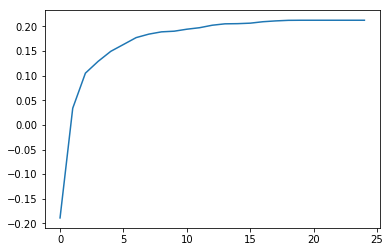

In [30]:
from sklearn import metrics
#get a list of all the trees (estimators), call predict on it. list of arrays(all predictions of one tree) of predictions 
#then concat them on an axis
preds = np.stack([t.predict(X_valid) for t in m3.estimators_])
#take the mean of all the predictions
preds[:,0], np.mean(preds[:,0]), y_valid[0]

#take the mean of the prediction, taking trees up to the i-th tree. 
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(25)]);

If we look at how adding more trees affects the accuracy, it is clear that adding lots more trees isn't making it better. Let's go back to the default of 10 or just stick with 20

In [31]:
# preds = np.stack([t.predict(X_valid) for t in m2.estimators_])

# preds[:,0], np.mean(preds[:,0]), y_valid[0]

# plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(25)]);

In [24]:
# m4 = RandomForestRegressor(n_estimators=20, n_jobs=-1, oob_score=True)
# m4.fit(X_train, y_train)
# print_score(m4)

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[55.80867401226208, 86.37204078130078, 0.6933675180637351, 0.253268112161823, 0.5808365935671966]


In [46]:
# test = m.predict_proba(porg2)

In [47]:
# probs_test_x = X_valid.loc[108660]
# porg = array(probs_test_x)
# porg2=porg.reshape(1,-1)

In [48]:
# corr = merged.corr()


In [49]:
# import seaborn as sns
# f , ax = plt.subplots(figsize = (14,12))

# plt.title('Correlation Matrix',y=1,size=16)

# sns.heatmap(corr,square = False,  vmax=0.8)

In [29]:
import pickle 

with open('temp_model.pkl','wb') as pickle_file:
    pickle.dump(m3, pickle_file)

In [28]:
m4.feature_importances_

array([0.242572, 0.066911, 0.016673, 0.032041, 0.119197, 0.03724 , 0.016783, 0.036757, 0.086208, 0.075382, 0.118545,
       0.036621, 0.105712, 0.00236 , 0.003832, 0.003165, 0.      ])

In [40]:
# print(raw_train.common.cat.codes.head(20))
# print(raw_train.common.head(20))

In [41]:
# data.common.cat.codes.unique()

In [42]:
# data.common.unique()

In [43]:
# mapping = pd.DataFrame()
# mapping['common_name']=data.common.unique()
# mapping['code']=data.common.cat.codes.unique()

In [52]:
data2.DIST.max()

8.0

In [23]:
mapping = []
for column in data2:
    df = pd.DataFrame()
    df[f'{column}']=data2[column].unique()
    try:
        df['code']=data2[column].cat.codes.unique()
    except:
        df['code']=data[column].max()
    mapping.append(df)

In [41]:
data2.common.cat.codes.unique()
# data2.common.unique()

array([ 18,  15, 220, 277, ..., 163, 312,  41, 266])

In [27]:
with open('mapping.pkl','wb') as pickle_file:
    pickle.dump(mapping, pickle_file)

In [42]:
data.common.unique()

array(['ATLANTIC SILVERSIDE', 'ATLANTIC MENHADEN', 'SCUP', 'TAUTOG', ..., 'NEEDLEFISH FAMILY', 'YELLOWMOUTH GROUPER',
       'BLACKFIN SNAPPER', 'SQUIRRELFISH FAMILY'], dtype=object)

In [ ]:
1 = Open water 
2 = Sound 
3 = River 
4 = Bay 
5 = Other 
A = Narragansett Estuary 
B = Buzzards Bay Estuary 
C = Long Island Estuary 
D = Hudson/Raritan Estuary 
E = Delaware Estuary 
F = Chesapeake Estuary 
G = Albemarle/Pamlico Estuary 
H = Biscayne Estuary 
I  = Whitewater Estuary 
J = Sarasota Estuary 
K = Tampa Estuary 
L = Mobile Estuary 
M = Atchafelaya Estuary 
N = Boqueron Estuary 
O = Guanica Estuary 
P = Guayanilla Estuary 
Q = Humacao Estuary 
R = Jobos Estuary 
S = San Juan Estuary 
T =Tortuguero Estuary 
V = Cape Cod Bay

In [60]:
mapping[1]

,SUB_REG,code
0,4,7
1,5,7
2,6,7
3,7,7


# mapping.to_csv('name_map.csv', index=False)

In [45]:
# mapping.head()

In [51]:
# mapping = pd.read_csv('name_map.csv',index_col='common_name')

In [52]:
# mapping.head()

In [53]:
# mapping.columns

In [54]:
# mapping.loc['BLUEFISH', 'code']

In [55]:
# mapping.index

In [56]:
# mapping.loc[mapping['code'] == 23].index


In [62]:
data2.head()

,prim1_common,SUB_REG,AREA,AREA_X,MODE_FX,BOAT_HRS,month,CNTRBTRS,FFDAYS12,common
9,NONE,4,C,5,3,NaN,9,1.0,100.0,ATLANTIC SILVERSIDE
13,BLUEFISH,4,C,5,3,NaN,9,1.0,20.0,ATLANTIC MENHADEN
14,BLUEFISH,4,C,5,3,NaN,9,1.0,20.0,ATLANTIC MENHADEN
15,BLUEFISH,4,C,5,3,NaN,9,1.0,20.0,ATLANTIC MENHADEN
16,BLUEFISH,4,C,5,3,NaN,9,1.0,20.0,ATLANTIC MENHADEN
